# **Greedy algorithm**
This lab focuses on performing a greedy algorithm on the parametric system we saw together in the previous lab.

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim # To reduce the space
from scipy.sparse.linalg import splu
import time

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{base} \text{  Neumann}\\
u = 0 & \text{in } \Gamma_{top} \text{  Dirichlet}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k_{\mu} = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise. 
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.

<img src="../Images/domain.png"
 style="float:center;" align="center">


The parameter $\boldsymbol \mu \in \mathcal P$ is physical and changes the features of the flow: 

1. $\mu_1$ the conductivity in $\Omega_1$;
2. $\mu_2$ describes the heat flux in the bottom part of the boundary.

First thing: we define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk in the origin with radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$.
3. $\Gamma_{base}$ to define where we will change the heat flux.


In [4]:
# Describe the domain

def Heat_R(): # Radius
	return 0.5


def Omega1(numPoints, points): # The disk
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0.
	return values.ctypes.data

def Omega2(numPoints, points): # Outside the disk
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def Gamma_base(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

##### needed for the inner product #####

def Domain(numPoints, points): # All the domain (1 allover the domain)
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data	

**Goal**: build the ROM space where many simulations for several parameters can be performed in a smaller amount of time. *Another way to build the ROM*, a "smarter" way to solve it --> especially in the offline phase.

**Strategy**: $w(\boldsymbol  \mu)  \xrightarrow[]{\text{FOM} (\dim = \mathcal N)} w^{\mathcal N}(\boldsymbol \mu)
\xrightarrow[\lvert \lvert {w(\boldsymbol \mu) - w^\mathcal{N}(\boldsymbol  \mu)\rvert \rvert } \rightarrow 0]{\text{ROM } (\dim N)} w_N(\boldsymbol  \mu)$.

The goal can be reached by means of several techniques. 

Today we will focus on Greedy.

Building the space $\mathbb V_N \subset \mathbb V^{\mathcal N}$ and store the $\boldsymbol \mu-$independent quantities is the so called _offline phase_ (possibly costly).

Once the space is built, a fast _online phase_ occurs, where I can compute **many solutions in real-time**.

We still use the affine decomposition property. Indeed we know that our system can be written as

$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)a_i(u,v) = \sum_{j=0}^{q_f} \theta_j^f(\boldsymbol \mu)f_j(v),
$$

i.e., algebraic-wise (evething is affine, so separable)

$$
\mathbb{A}(\boldsymbol \mu) = \sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu) \mathbb{A}_i = \sum_{j=1}^{q_f} \theta_j^f(\boldsymbol \mu)\mathbf f_j = \mathbf f(\boldsymbol \mu),
$$
where $\mathbb{A}_i$ and $\mathbf f_j$ are the assembled matrices and vectors of the system.

Now, let us imagine to have already built the reduced space and have collected the basis functions $\xi_{i} \in \mathbb R^{\mathcal N}$ for $i \in \{1, \dots, N \}$ ($\mathbb V_N = \text{span}\{\xi_i\}_{i=1}^{N} $) in a basis matrix 
$$
\mathbb B = [\xi_1 \cdots \xi_N] \in \mathbb R^{\mathcal N \times N}.
$$ 

It is clear that we can recast the problem in the low-dimensional framework we built, we can pre-and-post multiply the FOM matrices for the basis matrix we have:

$$
\mathbb{A}_i^N = \mathbb B^T \mathbb{A}_i\mathbb B \quad \text{ and } \quad  \mathbf f_j^N = \mathbb B^T\mathbf f_j.  
$$

During the offline phase, you project (thaks to the last formula) and take there to solve with different value, during the online phase.

**Let us code the OFFLINE PHASE**

In [5]:
### order of the discretization ###
order = 1

In [6]:
%%writefile ImportMesh.csv
InputFolderPath
../../CppToPython/Meshes/Mesh1

Writing ImportMesh.csv


In [8]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

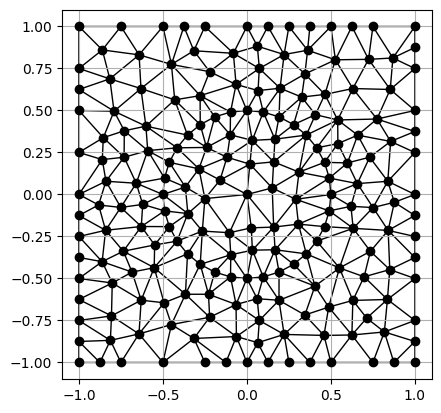

In [9]:
gedim.PlotMesh(mesh)

### FEM space (the High Fidelity approximation)

In [10]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

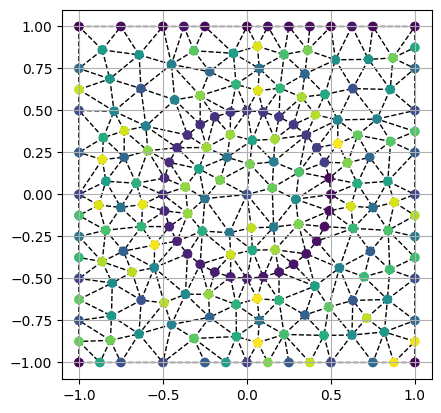

In [11]:
gedim.PlotDofs(mesh, dofs, strongs)

### Assemble linear system exploting affinity
We define everything that is parameter independent:
$$\mathbb{A}_i,\ i \in \{0,\dots, q_a\} \quad \mathbf{f}_j,\ j \in \{0,\dots, q_f\}.$$
Moreover, we define the matrix $\mathbb{X}$ related to the scalar product of the problem at hand.
Finally, we create the parameter dependent variable:
$$θ^a_i(\boldsymbol{\mu}),\ i \in \{0,\dots, q_a\} \quad θ^f_j(\boldsymbol{\mu}),\ j \in \{0,\dots, q_f\}$$


In [12]:
# Definition of the matrix
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega1, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega2, problemData, lib)

weakTerm_down1 = gedim.AssembleWeakTerm(Gamma_base, 1, problemData, lib)

#### inner product X
# ||u||^2 + ||grad(u)||^2
# Related to the inner product of the space
X = stiffness1 + stiffness2  # semi-norm (equivalent to the inner product norm)

### define the problem
# Put together all the A_i and f_j
AQH = [stiffness1, stiffness2] # Collecting the stiffness term
fQH = [weakTerm_down1] # Because the Neuman boundary condition is NOT homogeneus

def thetaA(mu): 
    return [1.0, mu[0]] # Term related to stiffness1 and stiffness2
def thetaF(mu):
    return [mu[1]] # Term related to weakTerm_down1

We will define some useful functions to perform computations:

```def normX(v, X):```
$u \in R^{\mathcal N}$, $||u||^2_X = u'Xu$, where $X \in \mathcal{R}^{\mathcal{N}, \mathcal{N}}$ 

In [13]:
# Functions usefull
def normX(v, X): # Norm of a vector wrt the matrix X: as in the other lab
	return np.sqrt(np.transpose(v) @ X @ v) # X := inner product matrix


def ProjectSystem(AQH, fQH, B):
    AQN = []
    fQN = []
    for AH in AQH:
        AQN.append(np.copy(np.transpose(B) @ AH @ B))
    for fH in fQH:
        fQN.append(np.copy(np.transpose(B) @ fH))
    return [AQN, fQN]

def Solve_full_order(AQH, fQH, thetaA_mu, thetaF_mu):  
    # Take high fidelity list
    A = thetaA_mu[0] * AQH[0]
    f = thetaF_mu[0] * fQH[0]

    # Assembling the system
    for i in range(1, len(AQH)):
        A += thetaA_mu[i] * AQH[i]
    for i in range(1, len(fQH)):
        f += thetaF_mu[i] * fQH[i]
    return gedim.LUSolver(A, f, lib) # With gedim

def Solve_reduced_order(AQN, fQN, thetaA_mu, thetaF_mu):
    # The same, but take the reduce versin of the matrix
    A = thetaA_mu[0] * AQN[0]
    f = thetaF_mu[0] * fQN[0]
    for i in range(1, len(AQN)):
        A += thetaA_mu[i] * AQN[i]
    for i in range(1, len(fQN)):
        f += thetaF_mu[i] * fQN[i]
    return np.linalg.solve(A, f) # With numpy

We here define the finite parametric space $\mathcal P_{train}$, with random uniform distributed realization of $\boldsymbol \mu$.
The cardinality of $\mathcal P_{train}$ is set to $M=100$, possible snapshot.

In [14]:
### define the training set
M = 100
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]
P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(M, P.shape[0]))

### POD

We recall POD algorithm. We will use it for comparisons.

To build the $N$ dimesional framework we need, we define the correlation snapshot matrix $\mathbb C \in \mathbb R^{M \times M}$ and we solve the eigenvalue problem
$
    \mathbb C \omega_n = \lambda_n \omega_n
$ for $ 1 \leq n \leq M,$ with $\lvert \lvert {\omega_n}\rvert \rvert_{\mathbb V} = 1$. 
Due to the definition of correlation matrix, we can order the all-positive eigenvalues as $\lambda_1 >\dots > \lambda_{M}> 0$ and retain the first $N$ eigenpairs $(\lambda_n, \omega_n)$ for $1 \leq n \leq N$, take in account $N$ largest eigenvalue. 

We choose $M$ and $N$ looking at the eigenvalues.
Indeed, defining as  $P_N: \mathbb V \rightarrow \mathbb V_N$ the projector from $\mathbb V$ onto $ {\mathbb V}_N$, the following relation holds:
\begin{equation}
    \sqrt{\frac{1}{M}
    \sum_{i = 1}^{M}  \lvert \lvert {u^{\mathcal N}(\boldsymbol{\mu}_{i}) - P_N(u^{\mathcal N}(\boldsymbol{\mu}_i)\rvert \rvert }_{\mathbb V}^2} < \sqrt{
    \sum_{i = N + 1}^{M}\lambda_m.}
\end{equation}
Namely, a fast decay of the eigenvalue magnitude guaratees a good representation of the high-fidelity solution with a few basis functions.

Finally, we create the basis matrix $\mathbb B$. 
There are many ways to build the bases.
We propose the following one to guarantee more stability:
$$    
\chi_n =  \sum_{m = 1}^{M} (\omega_n)_m u^{\mathcal N}(\boldsymbol{\mu}_m),  \quad \quad 1 \leq n \leq N,
$$
and $\displaystyle \xi_n = \frac{\chi_n}{\lvert \lvert \chi_n \rvert \rvert }_{\mathbb V}$.

In [15]:
# Collects all the block performe at the previuous laboratories
def POD(AQH, fQH, X, N_max, tol): # N_max := maximum number of basis function that I want
    #### snapshot matrix creation
    snapshot_matrix = []

    for mu in training_set:
        snapshot = Solve_full_order(AQH, fQH, thetaA(mu), thetaF(mu))  # Ful order
        snapshot_matrix.append(np.copy(snapshot))
    
    snapshot_matrix = np.array(snapshot_matrix) 

    ### covariance matrix
    C = snapshot_matrix @ X @ np.transpose(snapshot_matrix) # inner product
    L_e, VM_e = np.linalg.eig(C)
    eigenvalues = []
    eigenvectors = []

    for i in range(len(L_e)):
        eig_real = L_e[i].real
        eig_complex = L_e[i].imag
        assert np.isclose(eig_complex, 0.)
        eigenvalues.append(eig_real)
        eigenvectors.append(VM_e[i].real)

    total_energy = sum(eigenvalues)
    retained_energy_vector = np.cumsum(eigenvalues)
    relative_retained_energy = retained_energy_vector/total_energy

    # relative_retained_energy is NOT largerer enought, put N_max
    # otherwise, put N as the argmax that you find (+1 becuse python start from 0)
    if all(flag==False for flag in relative_retained_energy >= (1.0 - tol)):
        N = N_max
    else:
        N = np.argmax(relative_retained_energy >= (1.0 - tol)) + 1

    # Create the basis function matrix
    basis_functions = []
    for n in range(N):
        eigenvector =  eigenvectors[n]
        # basis = (1/np.sqrt(M))*np.transpose(snapshot_matrix)@eigenvector 
        basis = np.transpose(snapshot_matrix) @ eigenvector # As last time
        norm = normX(basis, X) # Normalize
        # norm = np.sqrt(np.transpose(basis)@basis)
        basis /= norm
        basis_functions.append(np.copy(basis))

    return [N, np.transpose(np.array(basis_functions))]

### Greedy

The **greedy generation** of the reduced basis space is an *iterative procedure* where at each iteration one new basis function is added and the overall precision of the basis set is improved. Alternative to POD.

**Why is it so smart?** If youwork with a complicated problem and time consumed. So I can compute exactly N (:= basis function) solution, I do not work with M snapshot, but only with N of them, so I have to solve few problem (N << M). The offline phase is really fast compare to the one of the POD.

The "ideal" version of the Greedy algorithm reads as:

Given a train set $\mathcal{P}_{train}$, define $u_0 (\mu) := 0$

\begin{align}
\text{for}\ &N \in \{1, \dots , N_{max}\}:\\
&\boldsymbol{\mu}_N = \text{arg}\max_{\boldsymbol{\mu} \in \mathcal{P}_{train}} ||u^{\mathcal{N}}(\boldsymbol{\mu})-u_{N-1}(\boldsymbol{\mu})||_V\\
&S_N = S_{N−1} \cup \boldsymbol{\mu}_N\\
&\mathbb{B}_N = \mathbb{B}_{N-1} \cup \text{span}\{u_N(\boldsymbol{\mu}_mathcal{N})\}
\end{align}

* ${\mu}_N$ := parameter that maximaze
* $\mathbb{B}_N$ := basis function matrix, enlarge the space

In this way, you are sure, that you're computing a better approximation of the parameter.

**BUT ISSUE**: it is NOT possible to compute ${\mu}_N$, so we cannot work with this exact estimation of the solution, but me work with a posteriori error bound.

Possible issues are:
* $M=|\mathcal{P}_{train}|$ high fidelity solutions;
* Suboptimality (heuristic).

To overcome the first we use a sharp, inexpensive **a posteriori error bound** that is very cheap to evaluate and NOT depend on $\mathcal{N}$, but only on the dimenison of $N$
$$||u^{\mathcal{N}}(\boldsymbol{\mu})-u_{N-1}(\boldsymbol{\mu})||_V \leq Δ_N(\boldsymbol{\mu})$$
thus the algorithm becomes:

\begin{align}
\text{for}\ &N \in \{1, \dots , N_{max}\}:\\
&\boldsymbol{\mu}_N = \text{arg}\max_{\mu \in \mathcal{P}_{train}} Δ_N(\boldsymbol{\mu})\\
&S_N = S_{N−1} \cup \boldsymbol{\mu}_N\\
&\mathbb{B}_N = \mathbb{B}_{N-1} \cup \text{span}\{u_N(\boldsymbol{\mu}_N)\}
\end{align}

****
**NOTE**
* Very fast to compute, but complicated to find a bound like $Δ_N$
* Shark := as close as possible to the real value $||u^{\mathcal{N}}(\boldsymbol{\mu})-u_{N-1}(\boldsymbol{\mu})||_V$
* We want to maximaxe the error estimator $Δ_N(\boldsymbol{\mu})$ --> NOT SIMPLE TO FIND FOR COMPLEX PROBLEM
* Go on untile the criterion is sotisfied (tolerance)
* There are **issue**, but the first one is realter to the computation of the error estimation, that can be computed only for some cathegories of equations: it is very complicated to find an estimation 
* Greedy: has an error certification, so this means that this inequality $||u^{\mathcal{N}}(\boldsymbol{\mu})-u_{N-1}(\boldsymbol{\mu})||_V \leq Δ_N(\boldsymbol{\mu})$ certificates how the error decay
* POD basis is orthonormal by construction, in the greedy setting the snapshots are **not** (necessarily) orthogonal.
In order to obtain an orthonormal basis we rely on the **Gram-Schmidt
orthonormalization**, for $n > 1$:
$$z_n = u^{\mathcal{N}}(\boldsymbol{\mu}_n)-\sum_{i=0}^{N-1} (u^{\mathcal{N}}, \xi_i)_{\mathbb{X}}\xi_i$$


In [16]:
# Go on with the Greedy part
def GramSchmidt(V, u, X):
    z = u
    if np.size(V) > 0: # Basis function
        z = u - V @ (np.transpose(V) @ (X @ u)) # Apply normalization
    return z / normX(z, X) # Otherwise, just normalize

##### Greedy #####
# A lot of line that explain how to computer Δ_N in a proper way
def Greedy(AQH, fQH, X, N_max, tol): # High fidelity problem AQH, fQH
    N = 0
    basis_functions = []
    B = np.empty((0,0)) # Basis function matrix
    deltaN = tol + 1. # The first initialization of the delta
    training_set_list = training_set.tolist() # Peak un initial move randomly
    initial_muN = np.random.choice(len(training_set_list) - 1, 1)[0]
    muN = training_set_list.pop(initial_muN)
    invX = splu(X) # Saving the inner product matrix as a sparse matrix with LU decomposition

    print('Perfom greedy algorithm...')
    # I have at least one parameter in my list
    while len(training_set_list) > 0 and N < N_max and deltaN > tol:
        N = N + 1 
        print('\t', N,'/', N_max, '-', '{:.16e}'.format(np.mean(deltaN)), '/', '{:.16e}'.format(np.mean(tol)))
        # Take the snapshot, because you select a random begin (before)
        snapshot = Solve_full_order(AQH, fQH, thetaA(muN), thetaF(muN))
        basis_function = GramSchmidt(B, snapshot, X) # Function at the begin of this cell
        basis_functions.append(np.copy(basis_function))
        B = np.transpose(np.array(basis_functions))
        BX = np.transpose(B) @ X @ B # Defintion of BX with inner product
        
        # Use to builf the error
        [AQN, fQN] = ProjectSystem(AQH, fQH, B)
        [Cq1q2, dq1q2, Eq1q2] = OfflineResidual(AQH, fQH, B, invX) # Define in a few cell

        counter = 0
        mu_selected_index = -1
        max_deltaN = -1.
        for mu in training_set_list:
            solN_mu = Solve_reduced_order(AQN, fQN, thetaA(mu), thetaF(mu))
            betaN_mu = InfSupConstant(mu)
            # Way to compute the error estimation
            deltaN_mu = ErrorEstimate(Cq1q2, dq1q2, Eq1q2, thetaA(mu), thetaF(mu), solN_mu, betaN_mu) / normX(solN_mu, BX)

            # Just to check that everithing is going well
            if deltaN_mu > max_deltaN:
                max_deltaN = deltaN_mu
                mu_selected_index = counter

            counter = counter + 1

        if mu_selected_index == -1:
            raise Exception('ERROR, parameter not found')

        muN = training_set_list.pop(mu_selected_index)
        deltaN = max_deltaN

    return [N, np.transpose(np.array(basis_functions))]

**How to computer the estimator** $Δ_N(\boldsymbol{\mu})$ **?**

To compute the estimator $Δ_N(\boldsymbol{\mu})$ we rely on the error bound
$$\frac{1}{\gamma^{\mathcal{N}}(\boldsymbol{\mu})} ||r(\boldsymbol{\mu})||_{\mathbb{V}'}\leq ||e^{\mathcal{N}}(\boldsymbol{\mu})|| \leq \frac{1}{\beta^{\mathcal{N}}(\boldsymbol{\mu})} ||r(\boldsymbol{\mu})||_{\mathbb{V}'}  $$

where $e^{\mathcal{N}}(\boldsymbol{\mu}) := u^{\mathcal{N}}(\boldsymbol{\mu})-u_{N}(\boldsymbol{\mu})$ and $r(\boldsymbol{\mu}) \in \mathbb{V}'$ is the **residual** of the high-fidelity problem computed on the reduced solution, $\forall v \in \mathbb{V}$:
$$_{\mathbb{V}'} \langle r(\boldsymbol{\mu}), v  \rangle_{\mathbb{V}} = r(v; \boldsymbol{\mu}) := f(v; \boldsymbol{\mu}) - a(u_N(\boldsymbol{\mu}), v; \boldsymbol{\mu})$$

Imagine to have a problem $a(u,v;\mu)=f(v) \forall v \in V$ for a given $\mu \in P$, the parametric step. The **well-posedness** is related to prove existence and uniquity of the solution:
* f is contiunous
* a is continuous
* a is inf-sup stable:
   
\begin{align*}
\exists! \beta_0 &> 0 \text{ s.t.} \\
\beta^{\mathcal{N}} = \inf_{v \in V} \sup_{u \in V} \frac{a(u, v; \mu)}{\|u\| \|v\|} &\geq \beta_0 > 0 \\
\text{and} \quad \\
\sup_{u \in V} \inf_{v \in V} \frac{a(u, v; \mu)}{\|u\| \|v\|} &> 0
\end{align*}

*NB* The cohercivity implies the inf-sup stable

From the error bound, we define 
$$Δ_N(\boldsymbol{\mu}) := \frac{||r(\boldsymbol{\mu})||_{\mathbb{V}'}}{\beta^{\mathcal{N}}(\boldsymbol{\mu})}$$

To compute algebrically $Δ_N(\boldsymbol{\mu})$ we define the algebraic residual
$$r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu}) := \mathbb{f}(\boldsymbol{\mu}) - \mathbb{A}(\boldsymbol{\mu}) \mathbb{B} u_{N}(\boldsymbol{\mu})$$
and we see from the definition that
$$\mathbb{A}(\boldsymbol{\mu}) e^{\mathcal{N}}(\boldsymbol{\mu}) = r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})$$
****
**Estimator $Δ_N(\boldsymbol{\mu})$ in $||\cdot||_2$**

Taking the $l^2$-norm on both side of the previous identity we obtain:
$$||e^{\mathcal{N}}(\boldsymbol{\mu})||_2 \leq ||\mathbb{A}^{-1}(\boldsymbol{\mu})||_2 ||r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_2 = \frac{1}{σ_{min}(\mathbb{A}(\boldsymbol{\mu}))} ||r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_2$$

****
**Estimator $Δ_N(\boldsymbol{\mu})$ in $||\cdot||_{\mathbb{X}^{-1}}$**

We want to work with the norm of the inner product, so we can rewrite the previuous inequality in a differnt way. Similarly as before, we multiply the previous identity by $\mathbb{X}^{\frac{1}{2}}$, thus :
$$||\mathbb{X}^{\frac{1}{2}}e^{\mathcal{N}}(\boldsymbol{\mu})||_2 \leq ||\mathbb{X}^{\frac{1}{2}}\mathbb{A}^{-1}(\boldsymbol{\mu})\mathbb{X}^{\frac{1}{2}}||_2 ||\mathbb{X}^{-\frac{1}{2}}r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_2 = \frac{1}{σ_{min}(\mathbb{X}^{-\frac{1}{2}}\mathbb{A}(\boldsymbol{\mu})\mathbb{X}^{-\frac{1}{2}})} ||\mathbb{X}^{-\frac{1}{2}} r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_2$$
obtaining
$$||e^{\mathcal{N}}(\boldsymbol{\mu})||_{\mathbb{X}} \leq \frac{1}{\beta^{\mathcal{N}}(\boldsymbol{\mu})}||r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_{\mathbb{X}^{-1}}$$
as it is possible to show that $\beta^{\mathcal{N}}(\boldsymbol{\mu}) = σ_{min}(\mathbb{X}^{-\frac{1}{2}}\mathbb{A}(\boldsymbol{\mu})\mathbb{X}^{-\frac{1}{2}})$ if $\mathbb{A}(\boldsymbol{\mu})$ is symmetric.

****
**Offline-Online $Δ_N(\boldsymbol{\mu})$ Computation**

Basicly, we now can compute $Δ_N$ that is a very good approximation, but has to be also quite easy to compute. BUT, how can i compute the residual $||r(\boldsymbol{\mu})||_{\mathbb{V}'}$? If the problem is affine, we can exploit the separation of the variable to compute it.
If the affine assumption is valid, than
\begin{align}
||r^{\mathcal{N}}(u_{N}; \boldsymbol{\mu})||_{\mathbb{X}^{-1}} = &\sum_{q_1=1}^{q_f}\sum_{q_2=1}^{q_f} \theta_{q_1}^f(\boldsymbol \mu) \theta_{q_2}^f(\boldsymbol \mu) \underbrace{\mathbf{f}^T_{q_1} \mathbb{X}^{-1} \mathbf{f}_{q_2}}_{C_{q_1, q_2}}\\
-2 &\sum_{q_1=1}^{q_a}\sum_{q_2=1}^{q_f} \theta_{q_1}^a(\boldsymbol \mu) \theta_{q_2}^f(\boldsymbol \mu) u^T_N(\boldsymbol \mu) \underbrace{\mathbb{B}^T\mathbb{A}^T_{q_1} \mathbb{X}^{-1} \mathbf{f}_{q_2}}_{\mathbf{d}_{q_1, q_2}}\\
&\sum_{q_1=1}^{q_a}\sum_{q_2=1}^{q_a} \theta_{q_1}^a(\boldsymbol \mu) \theta_{q_2}^a(\boldsymbol \mu) u^T_N(\boldsymbol \mu) \underbrace{\mathbb{B}^T\mathbb{A}^T_{q_1} \mathbb{X}^{-1} \mathbb{A}_{q_2}\mathbb{B}}_{\mathbb{E}_{q_1, q_2}} u_N(\boldsymbol \mu)
\end{align}

So now the residual is a function that we can use to compute it during the offline phase, because does not depend on the parameter.
Like always, obviously, NOT inverte the matrix, but solve le linear system associated.

****
**NB** Consider the piece of code
```def InfSupConstant(mu):```
We want to approximate $$ \int_{\Omega_1} \nabla u \nabla v + \mu_1 \int_{\Omega_2} \nabla u \nabla v \geq \text{ min } \{1, \mu_1\} \int_{\Omega} \nabla u \nabla v$$ in a faster way, so we just use this code ```np.min(thetaA(mu)) ```


In [17]:

def OfflineResidual(AQH, fQH, B, invX):
    Cq1q2 = [] 
    dq1q2 = []
    Eq1q2 = []

    for q1 in range(0, len(AQH)):
        Z = invX.solve(AQH[q1] @ B) # This is the solution of the system Xz=f
        
        aqh_list = []
        for q2 in range(0, len(AQH)):
            aqh_list.append(np.copy(np.transpose(Z) @ AQH[q2] @ B)) # All the computation in the last formula
        Eq1q2.append(aqh_list.copy())
        
        fqh_list = []
        for q2 in range(0, len(fQH)):
            fqh_list.append(np.copy(np.transpose(Z) @ fQH[q2]))
        dq1q2.append(fqh_list.copy())

    for q1 in range(0, len(fQH)):
        t = invX.solve(fQH[q1])
        
        fqh_list = []
        for q2 in range(0, len(fQH)):
            fqh_list.append(np.copy(np.transpose(t) @ fQH[q2]))
        Cq1q2.append(fqh_list.copy())

    return [Cq1q2, dq1q2, Eq1q2]
    
def InfSupConstant(mu):
    return np.min(thetaA(mu)) # I decide this so that it is easy to compute

def ErrorEstimate(Cq1q2, dq1q2, Eq1q2, thetaA_mu, thetaF_mu, solN, beta):
    # Thaks all the parameters and compute the residual, thaks to what
    # I have already computed before in the offline phase
    fError = 0.0
    for q1 in range(0, len(Cq1q2)):
        for q2 in range(0, len(Cq1q2[q1])):
            fError += thetaF_mu[q1] * thetaF_mu[q2] * Cq1q2[q1][q2]
    
    uError = 0.0
    for q1 in range(0, len(Eq1q2)):
        for q2 in range(0, len(Eq1q2[q1])):
            uError += thetaA_mu[q1] * thetaA_mu[q2] * np.transpose(solN) @ Eq1q2[q1][q2] @ solN
    
    fuError = 0.0
    for q1 in range(0, len(dq1q2)):
        for q2 in range(0, len(dq1q2[q1])):
            fuError += thetaA_mu[q1] * thetaF_mu[q2] * np.transpose(solN) @ dq1q2[q1][q2]
    
    deltaN_squared = fError - 2.0 * fuError + uError
    if abs(deltaN_squared) <= 1.0e-12: # protect cancellation error
        deltaN_squared = 0.0
    elif deltaN_squared < 1.0e-12:
      raise Exception('deltaN_squared is negative')
    
    return np.sqrt(deltaN_squared) / beta

### Offline Phase


In [18]:
tol = 1.0e-7
N_max = 20

We perform now the POD as for comparison:

In [19]:
### Compute POD
[N_POD, B_POD] = POD(AQH, fQH, X, N_max, tol)
print("N_POD", N_POD)

[AQN_POD, fQN_POD] = ProjectSystem(AQH, fQH, B_POD)

N_POD 3


Now the greedy with the same parameters

In [20]:
### Compute Greedy that produce the result in a few iteration

[N_Greedy, B_Greedy] = Greedy(AQH, fQH, X, N_max, tol)
print("N_Greedy", N_Greedy)

[AQN_Greedy, fQN_Greedy] = ProjectSystem(AQH, fQH, B_Greedy)

Perfom greedy algorithm...
	 1 / 20 - 1.0000001000000001e+00 / 9.9999999999999995e-08
	 2 / 20 - 2.6128199821872582e+00 / 9.9999999999999995e-08
	 3 / 20 - 9.5869725721470043e-03 / 9.9999999999999995e-08
	 4 / 20 - 3.6023678917312355e-04 / 9.9999999999999995e-08
	 5 / 20 - 1.7725856136694674e-05 / 9.9999999999999995e-08
	 6 / 20 - 1.1298503708636705e-06 / 9.9999999999999995e-08
N_Greedy 6


### Online Phase

In the _online phase_ we can use all the pre-assembled quantities to generate a new solution for a new parameter. 



In [21]:
thetaA2 = 2.
thetaf1 = 0.8

In [22]:
def TestSingleParameter(AQH, fQH, AQN, fQN, B, mu):
    reduced_solution = Solve_reduced_order(AQN, fQN, thetaA(mu), thetaF(mu))
    full_solution = Solve_full_order(AQH, fQH, thetaA(mu), thetaF(mu))

    ###### plot #######
    proj_reduced_solution = B @ reduced_solution

    ### computing error
    error_function = full_solution - proj_reduced_solution
    error_norm_squared_component = np.transpose(error_function) @ X @ error_function
    abs_err = np.sqrt(abs(error_norm_squared_component))

    full_solution_norm_squared_component = np.transpose(full_solution) @  X @ full_solution
    rel_err = abs_err / np.sqrt(abs(full_solution_norm_squared_component))

    #gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, np.zeros(problemData['NumberStrongs']))
    #gedim.PlotSolution(mesh, dofs, strongs, full_solution, np.zeros(problemData['NumberStrongs']))
    
    return [rel_err, abs_err]

In [23]:
[rel_err_POD, abs_err_POD] = TestSingleParameter(AQH, fQH, AQN_POD, fQN_POD, B_POD, [thetaA2, thetaf1])
print("SingleParameter POD relative error = ", '{:.16e}'.format(np.mean(rel_err_POD)) )
print("SingleParameter POD absolute error = ", '{:.16e}'.format(np.mean(abs_err_POD)) )

[rel_err_Greedy, abs_err_Greedy] = TestSingleParameter(AQH, fQH, AQN_Greedy, fQN_Greedy, B_Greedy, [thetaA2, thetaf1])
print("SingleParameter Gdy relative error = ", '{:.16e}'.format(np.mean(rel_err_Greedy)) )
print("SingleParameter Gdy absolute error = ", '{:.16e}'.format(np.mean(abs_err_Greedy)) )

SingleParameter POD relative error =  5.3945864559692418e-05
SingleParameter POD absolute error =  4.8688449897487929e-05
SingleParameter Gdy relative error =  3.3182899012326324e-09
SingleParameter Gdy absolute error =  2.9948985509859141e-09


We can now compute an error analysis over the parametric space, together with a _speed-up_ anaslysis.

The speed-up is an index that evaluated how many ROM solution I can obtain in the time of a FOM simulation.

In [24]:
def Avg_error(AQH, fQH, AQN, fQN, B):
    ### compute avg error
    abs_err = []
    rel_err = []
    testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
    speed_up = []

    print("Computing error and speedup analysis...")

    for mu in testing_set:
        ##### full #####
        start_fom = time.time()
        full_solution = Solve_full_order(AQH, fQH, thetaA(mu), thetaF(mu))
        time_fom = time.time() - start_fom

        #### reduced #####
        start_rom = time.time()
        reduced_solution = Solve_reduced_order(AQN, fQN, thetaA(mu), thetaF(mu))
        time_rom = time.time() - start_rom

        speed_up.append(time_fom / time_rom)

        proj_reduced_solution = B @ reduced_solution # In order to compare
  
        ### computing error
        error_function = full_solution - proj_reduced_solution
        error_norm_squared_component = np.transpose(error_function) @ X @ error_function
        absolute_error = np.sqrt(abs(error_norm_squared_component))
        abs_err.append(absolute_error)

        full_solution_norm_squared_component = np.transpose(full_solution) @  X @ full_solution
        relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
        rel_err.append(relative_error)
    
    return [rel_err, abs_err, speed_up]

In [25]:
[rel_err_POD, abs_err_POD, speed_up_POD] = Avg_error(AQH, fQH, AQN_POD, fQN_POD, B_POD)
print("- Average POD relative error = ", '{:.16e}'.format(np.mean(rel_err_POD)) )
print("- Average POD absolute error = ", '{:.16e}'.format(np.mean(abs_err_POD)) )
print("- Average POD speed_up       = ", '{:.16e}'.format(np.mean(speed_up_POD)))

[rel_err_Greedy, abs_err_Greedy, speed_up_Greedy] = Avg_error(AQH, fQH, AQN_Greedy, fQN_Greedy, B_Greedy)
print("- Average Gdy relative error = ", '{:.16e}'.format(np.mean(rel_err_Greedy)) )
print("- Average Gdy absolute error = ", '{:.16e}'.format(np.mean(abs_err_Greedy)) )
print("- Average Gdy speed_up       = ", '{:.16e}'.format(np.mean(speed_up_Greedy)))

Computing error and speedup analysis...
- Average POD relative error =  9.1860528759290020e-05
- Average POD absolute error =  3.1203669769762208e-04
- Average POD speed_up       =  2.8738475343350686e+01
Computing error and speedup analysis...
- Average Gdy relative error =  2.2316406353069539e-09
- Average Gdy absolute error =  5.3320969962383727e-09
- Average Gdy speed_up       =  2.8116154914074517e+01
